Posted at
https://forums.fast.ai/t/share-your-v2-projects-here/65757/424?u=artyom

In [ ]:
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila 

from fastai.vision.all import *
from fastai.vision.widgets import *

path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])


# Classifier. Lesson 2. Detecting dolphins with Azure Functions

This lesson was easy to do for the ML part but hard for the deployment. Probably ratio is 30% on ML part and 70% on figuiring out how to deploy.

Results:

1. The REST function that classifies dolphines, sharks and sperm whales deployed at Azure Function: `https://animalsclassifier.azurewebsites.net/api/classify?code=l2c6qmnZTg95ZR6UICf1oTESfxp9aQ8AsEHH1dCwhVNiEHCA3cUl9g==&img=<YOUR PICTURE HERE>`
2. The model trained with ~7% error rate for that function.
3. Experience training ML model, deploying and running ML app locally and remotely.

I had this difficulties:

1. Getting good dataset. First I tried to do with orca. But I didn't find good dataset quickly. Bing API (not Bing) shows anything but orca. 
2. Training dataset. 
3. Hardest part was running it locally and deploying to Azure. Tried Binder, Heroku. But those were limitted success. Binder worked from time to time but turned off as it is free. Heroku didn't work for me (reported in another post) as it has limitted resources.
4. Deploying to Azure Functions was not straight forward. The article at https://course.fast.ai/deployment_azure_functions misleads in that local version won't run on remote server as numpy seems to have local dependencies (see below).

## Training model

Here is an example of bad dataset I had. It shows large error rate (23%).  

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

2
5


epoch,train_loss,valid_loss,error_rate,time
0,1.658646,1.480136,0.372093,00:10


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.770570,0.941606,0.302326,00:09
1,0.609715,0.761823,0.255814,00:09
2,0.507347,0.772947,0.244186,00:10
3,0.443193,0.776573,0.232558,00:09


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


And the confusion matrix doesn't look good also. It has a bias towards predicting dolphins more (6 and 8 for sperm whale and shark).

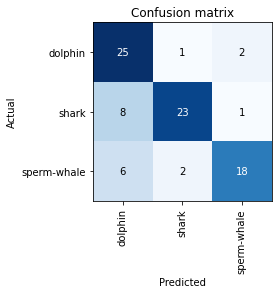

But another dataset with another pictures and it is find 6.9% error rate and most confused are dolphins and sperm-whales: only 4 out of 30 which is much better than the previous model with 14 out of 39 being confused as the picture above shows. Example of such a confusion below:

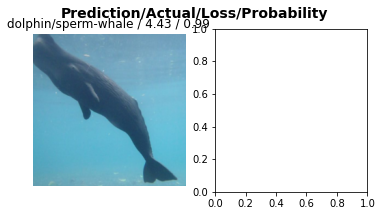

## Deployment

I followed [this great guide](https://medium.com/pytorch/efficient-serverless-deployment-of-pytorch-models-on-azure-dc9c2b6bfee7). This requires to install [Azure CLI](https://docs.microsoft.com/en-us/cli/azure/install-azure-cli) and [Azure Functions Core Tools](https://docs.microsoft.com/en-us/azure/azure-functions/functions-run-local?tabs=v4%2Clinux%2Ccsharp%2Cportal%2Cbash#v2). At Archilinux those are installed from AUR. After this we would need to create a function app with our function that would serve requests. Template for this at [here](https://github.com/Azure-Samples/functions-deploy-pytorch-onnx). In the end deployment is done with this command:

``` 
 func azure functionapp publish <AZURE FUNC APP NAME>
```

I found that the guide at https://course.fast.ai/deployment_azure_functions resulted for me in error "Importing the numpy c-extensions failed" because numpy version at remote server was wrong. So I fixed this by building remotely. For that I removed `--no-build` in `func azure` as in the above.


## Examples

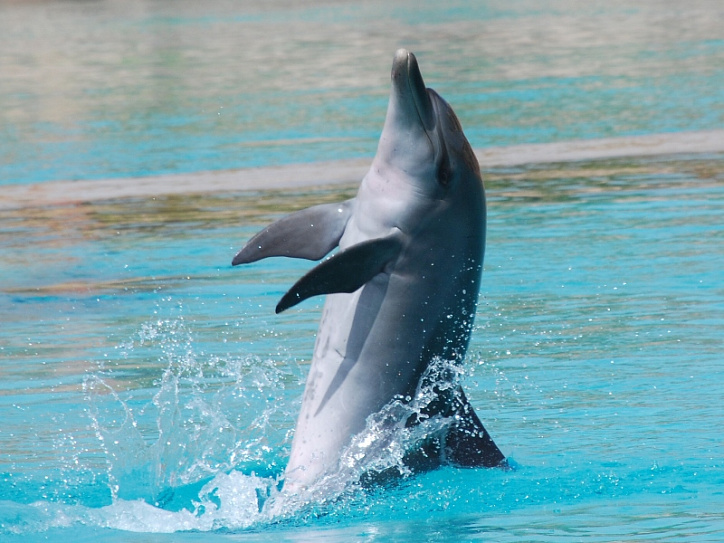

Shows 'dolphine' with 0.99 accuracy.
```
❯ curl 'https://animalsclassifier.azurewebsites.net/api/classify?code=l2c6qmnZTg95ZR6UICf1oTESfxp9aQ8AsEHH1dCwhVNiEHCA3cUl9g==&img=https://vetlechebnica74.ru/upload/resize_cache/iblock/cc0/965_543_1/xcc060102210c14dd273acd7cdc7450be.jpg.pagespeed.ic.KnENjtOl3n.jpg'
{
    "created": "2022-03-15T08:42:18.413865",
    "prediction": "dolphin",
    "latency": 103.03,
    "confidence": 0.9987719655036926
}%

```

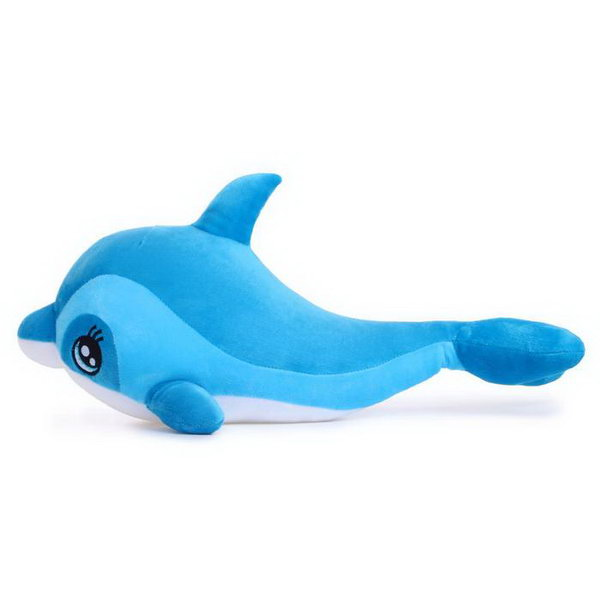

And that one: 'dolphine' with 0.61 accuracy:
```
❯ curl 'https://animalsclassifier.azurewebsites.net/api/classify?code=l2c6qmnZTg95ZR6UICf1oTESfxp9aQ8AsEHH1dCwhVNiEHCA3cUl9g==&img=https://static1.dom-podarka.ru/img/products/12/1227-222-dp1.jpg'
{
    "created": "2022-03-15T08:43:40.398392",
    "prediction": "dolphin",
    "latency": 108.61,
    "confidence": 0.6105219125747681
}
```


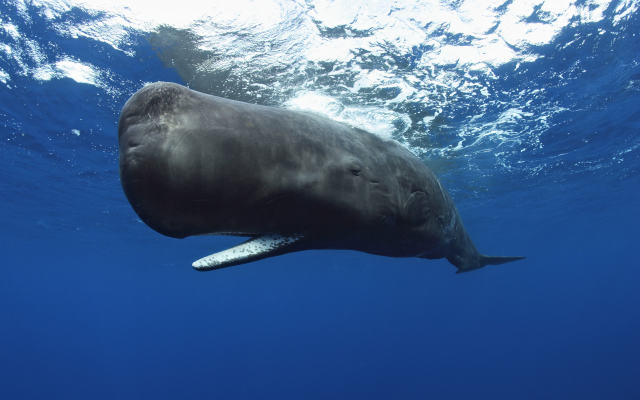

Sperm whale with 0.99

``` 
❯ curl 'https://animalsclassifier.azurewebsites.net/api/classify?code=l2c6qmnZTg95ZR6UICf1oTESfxp9aQ8AsEHH1dCwhVNiEHCA3cUl9g==&img=https://bonpic.com/wallpapers/large/2869.jpg'
{
    "created": "2022-03-15T08:45:50.201054",
    "prediction": "sperm-whale",
    "latency": 111.06,
    "confidence": 0.9998607635498047
}
```